<a href="https://colab.research.google.com/github/Gitterhubbajabba/ML_retail_analysis/blob/main/retailanalysis_ModelBuilder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")


np.random.seed(42)


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


print("Loading the online retail dataset...")
df = pd.read_csv('online_retail_II.csv')


print("\nDataset Overview:")
print(f"Shape: {df.shape}")
display(df.head())


print("\nOriginal Column Names:")
print(df.columns.tolist())

Loading the online retail dataset...

Dataset Overview:
Shape: (224099, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.25,13085.0,United Kingdom



Original Column Names:
['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']




## Preprocessing Visualization 1: Data Distribution
Analyzing the distribution of key features...


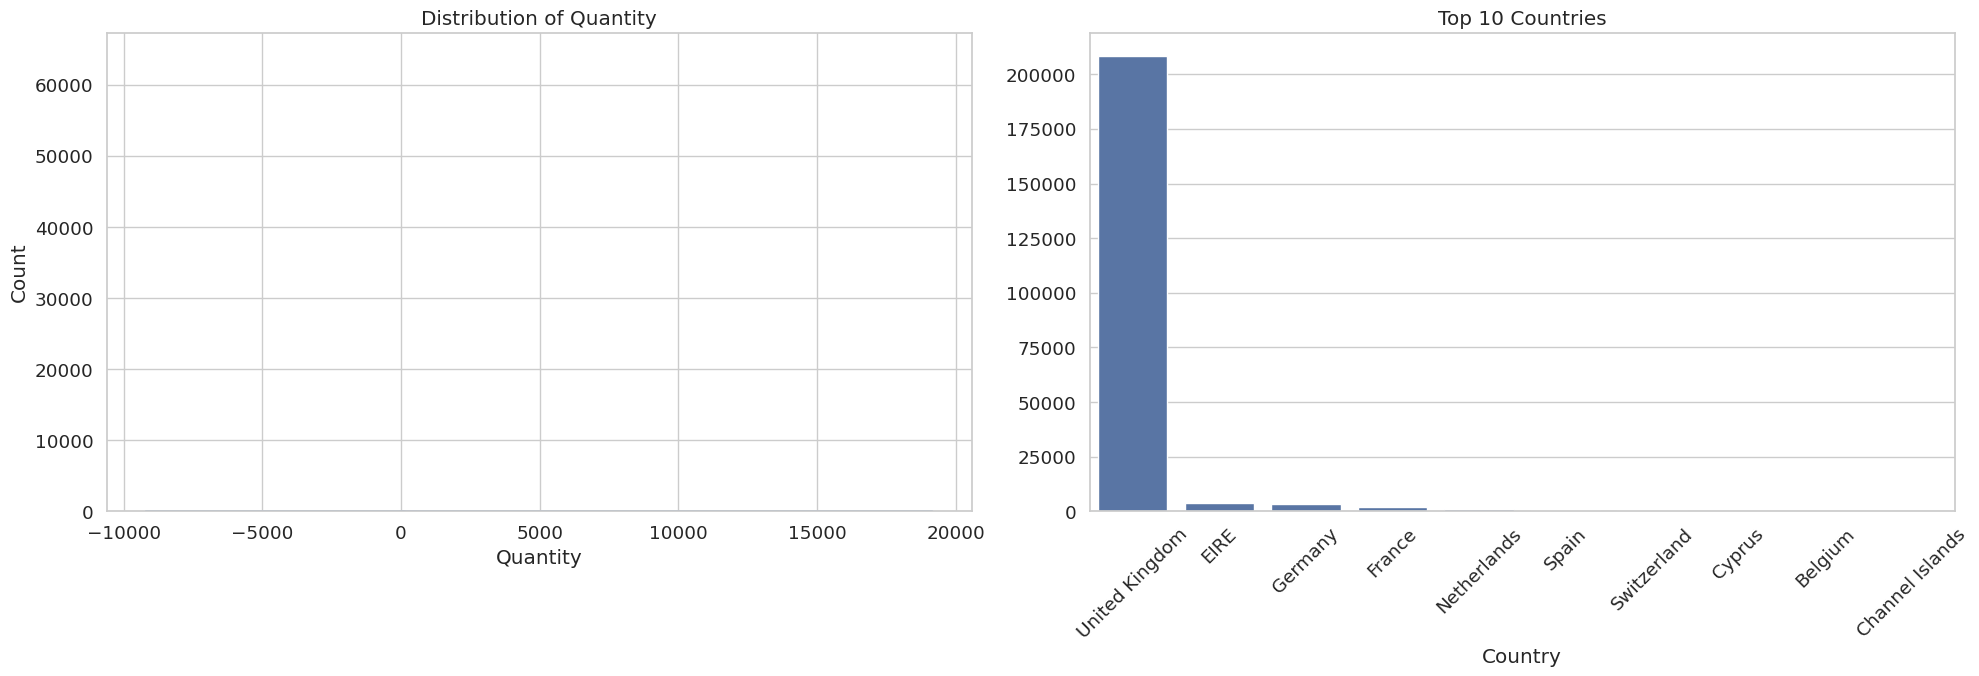

In [ ]:
print("\n\n## Preprocessing Visualization 1: Data Distribution")
print("Analyzing the distribution of key features...")

plt.figure(figsize=(20, 12))

categorical_cols = ['Country', 'CustomerID']
numerical_cols = ['Quantity', 'UnitPrice']
plot_index = 1
for col in numerical_cols:
    if col in df.columns:
        plt.subplot(2, 2, plot_index)
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Distribution of {col}')
        plt.tight_layout()
        plot_index += 1

if 'Country' in df.columns and plot_index <= 4:
    plt.subplot(2, 2, plot_index)
    top_countries = df['Country'].value_counts().head(10)
    sns.barplot(x=top_countries.index, y=top_countries.values)
    plt.title('Top 10 Countries')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plot_index += 1
if 'InvoiceNo' in df.columns and plot_index <= 4:
    plt.subplot(2, 2, plot_index)
    df['InvoiceMonth'] = pd.to_datetime(df['InvoiceDate']).dt.month_name() if 'InvoiceDate' in df.columns else pd.Series(dtype='object')
    monthly_invoices = df['InvoiceMonth'].value_counts().sort_index()
    sns.barplot(x=monthly_invoices.index, y=monthly_invoices.values)
    plt.title('Invoices by Month')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.savefig('data_distribution.png')
plt.show()


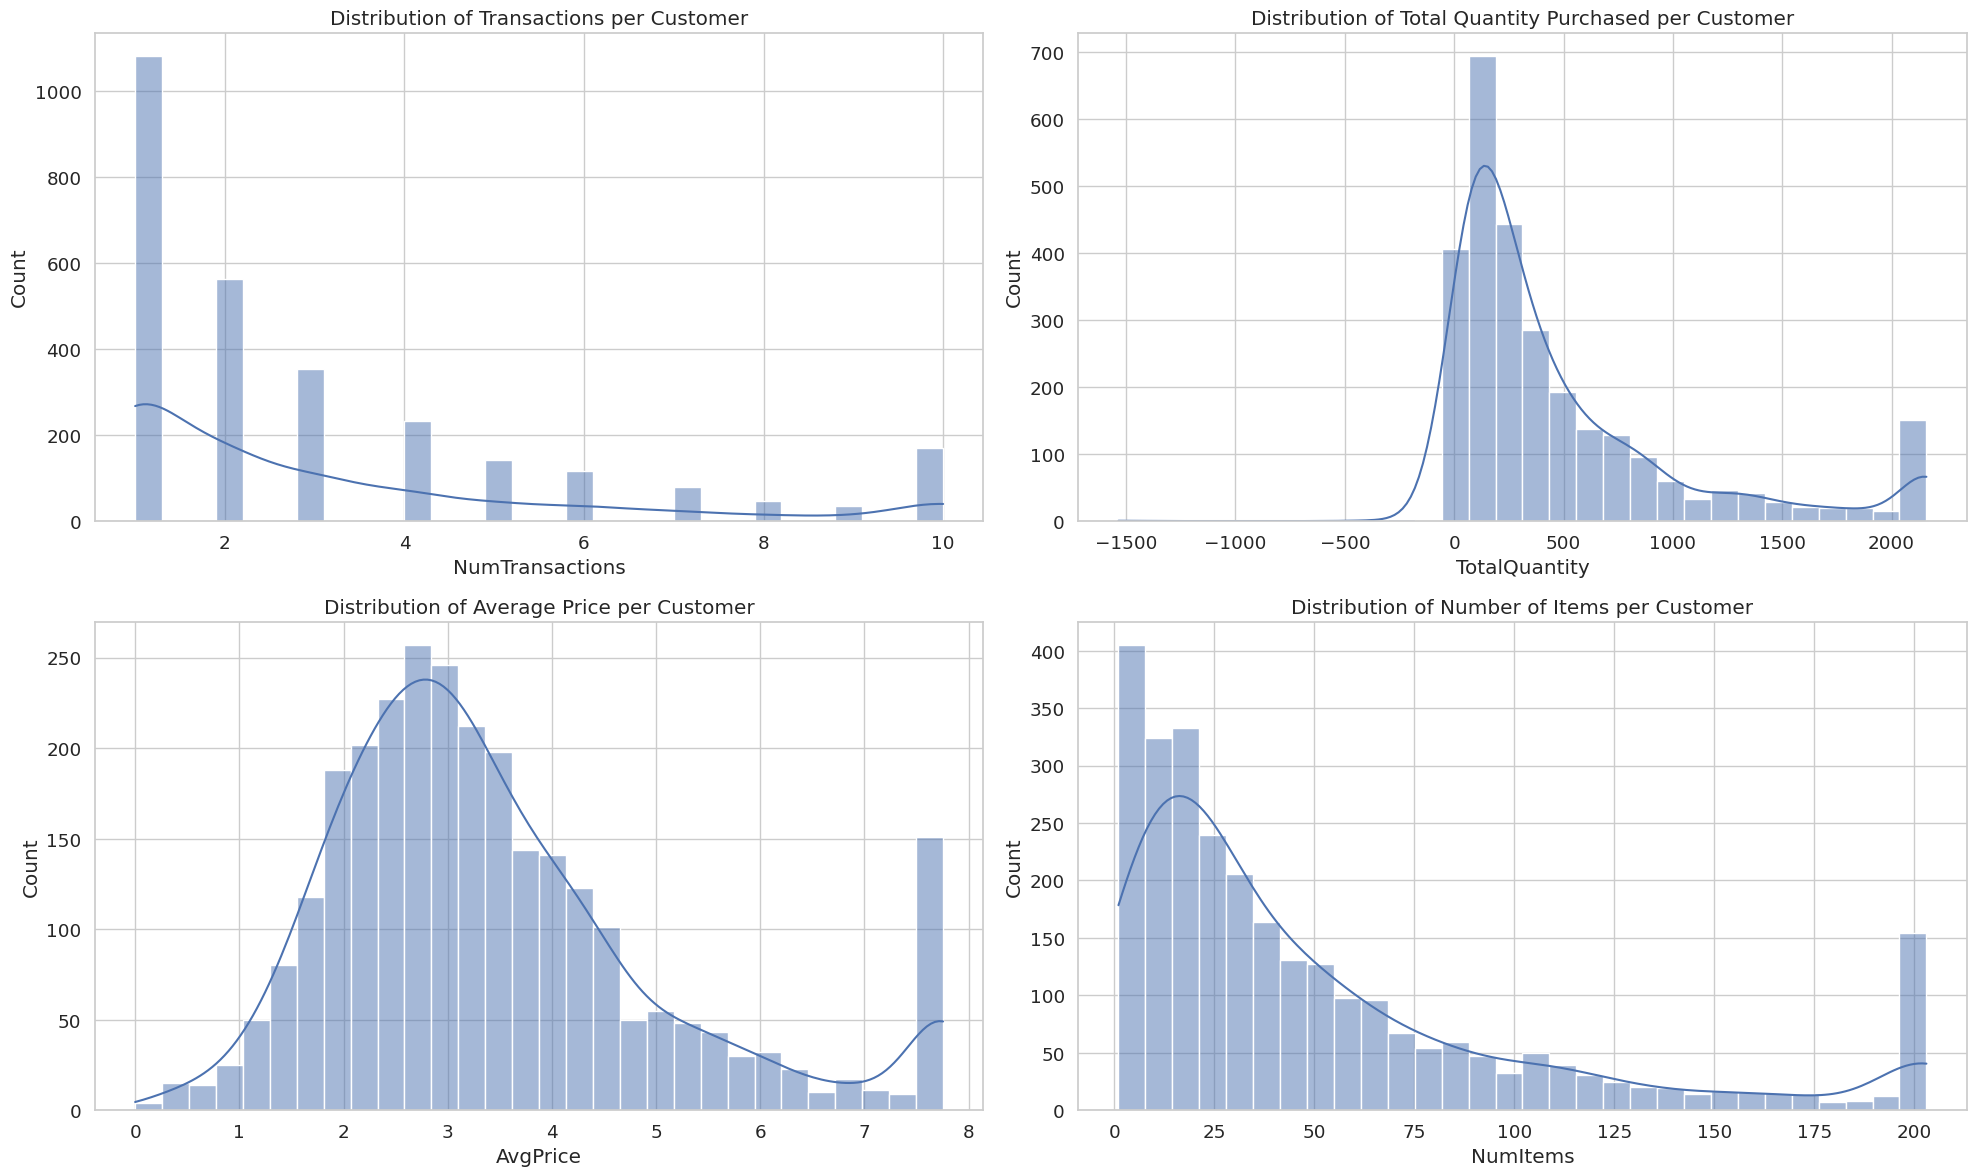

In [ ]:
plt.figure(figsize=(20, 12))

if 'Customer ID' in df.columns:
    df_customers = df.dropna(subset=['Customer ID'])

    customer_stats = df_customers.groupby('Customer ID').agg({
        'Invoice': 'nunique',
        'Quantity': 'sum',
        'Price': 'mean',
        'InvoiceDate': 'count'
    }).reset_index().rename(columns={
        'Invoice': 'NumTransactions',
        'Quantity': 'TotalQuantity',
        'Price': 'AvgPrice',
        'InvoiceDate': 'NumItems'
    })

    plt.subplot(2, 2, 1)
    sns.histplot(customer_stats['NumTransactions'].clip(upper=customer_stats['NumTransactions'].quantile(0.95)), bins=30, kde=True)
    plt.title('Distribution of Transactions per Customer')

    plt.subplot(2, 2, 2)
    sns.histplot(customer_stats['TotalQuantity'].clip(upper=customer_stats['TotalQuantity'].quantile(0.95)), bins=30, kde=True)
    plt.title('Distribution of Total Quantity Purchased per Customer')

    plt.subplot(2, 2, 3)
    sns.histplot(customer_stats['AvgPrice'].clip(upper=customer_stats['AvgPrice'].quantile(0.95)), bins=30, kde=True)
    plt.title('Distribution of Average Price per Customer')

    plt.subplot(2, 2, 4)
    sns.histplot(customer_stats['NumItems'].clip(upper=customer_stats['NumItems'].quantile(0.95)), bins=30, kde=True)
    plt.title('Distribution of Number of Items per Customer')

    plt.tight_layout()
    plt.savefig('customer_behavior.png')
    plt.show()
else:
    print("Customer ID column not found. Skipping customer behavior analysis.")

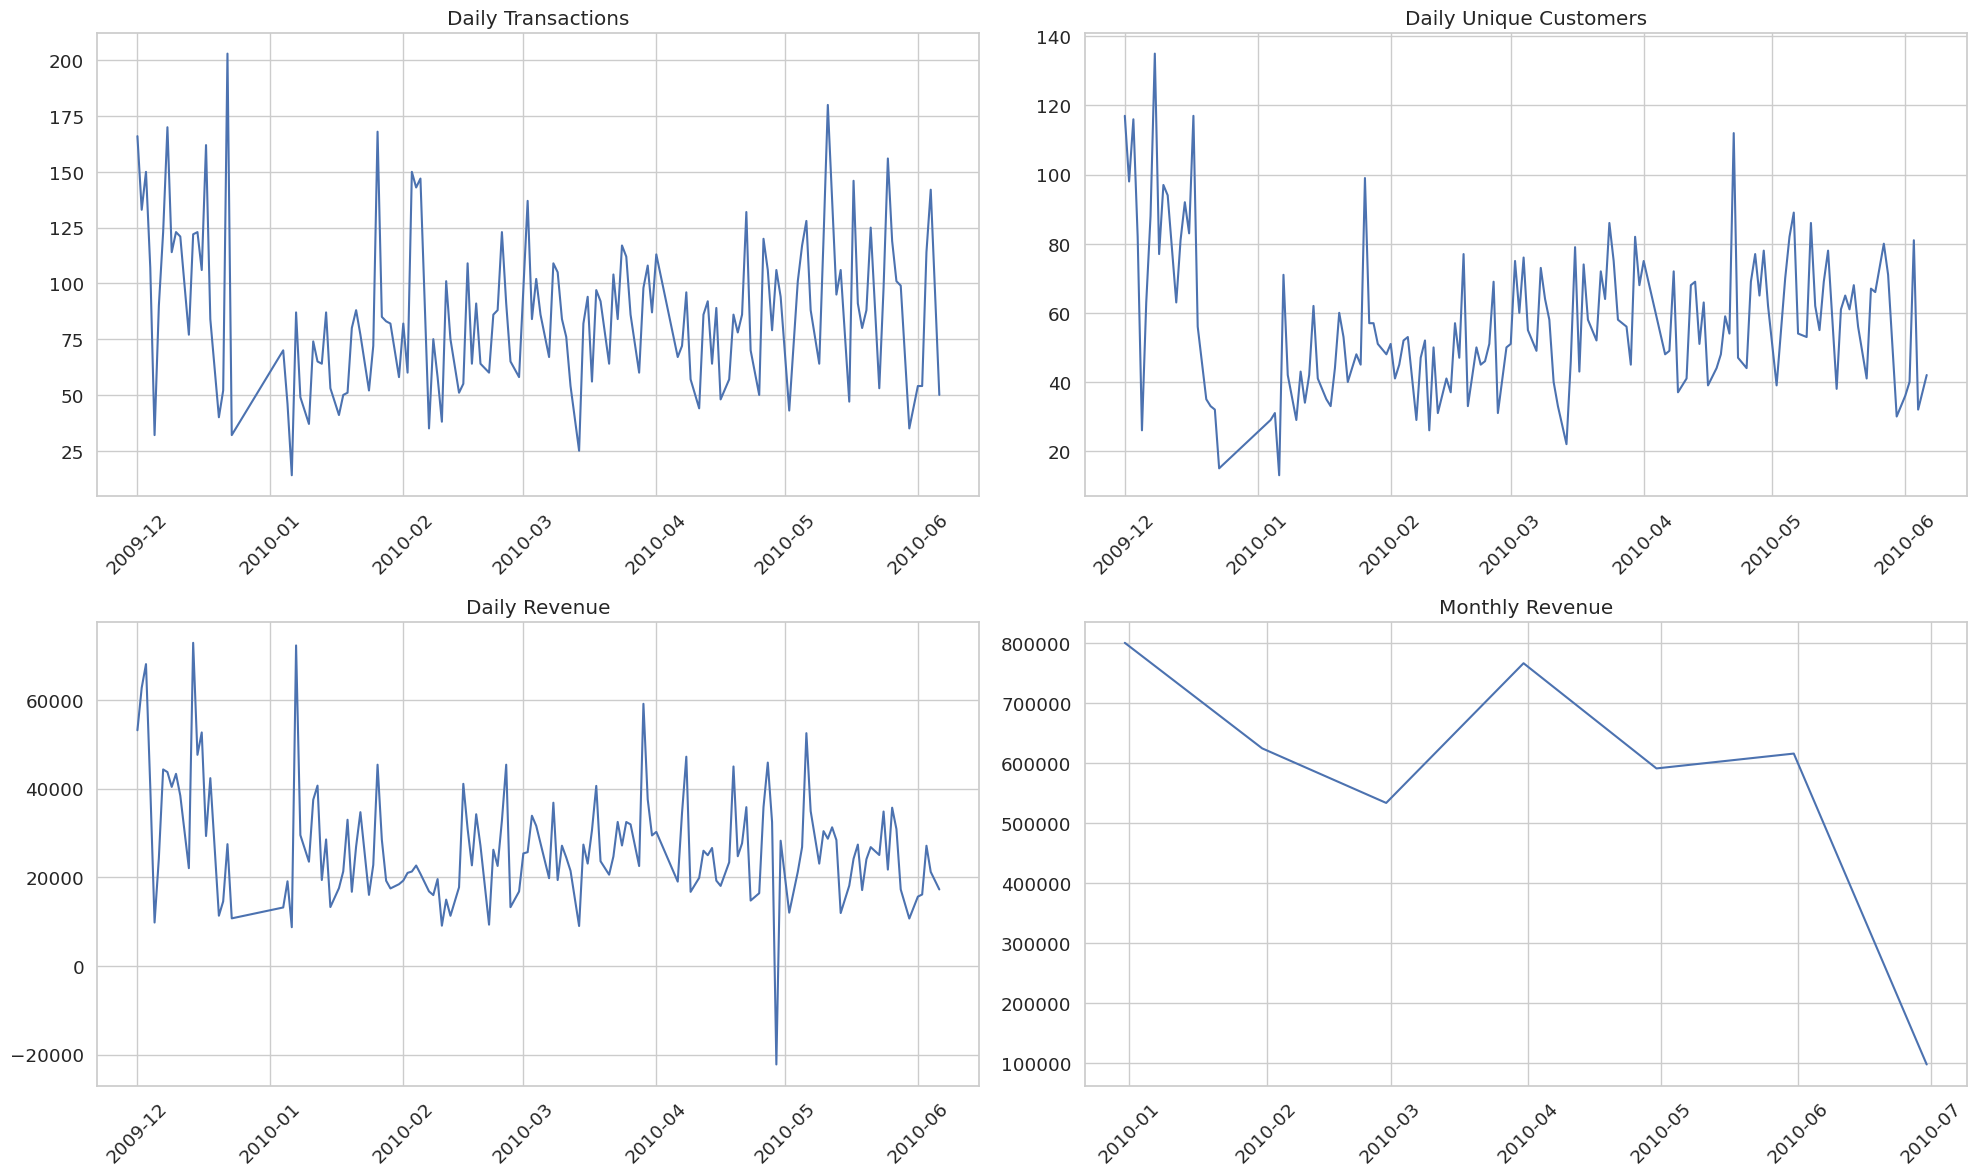

In [ ]:
plt.figure(figsize=(20, 12))

if 'InvoiceDate' in df.columns:
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

    if 'Revenue' not in df.columns:
        df['Revenue'] = df['Quantity'] * df['Price']

    daily_data = df.groupby(df['InvoiceDate'].dt.date).agg({
        'Invoice': 'nunique',
        'Customer ID': 'nunique',
        'Revenue': 'sum'
    }).reset_index()

    daily_data.columns = ['Date', 'NumTransactions', 'NumCustomers', 'Revenue']

    plt.subplot(2, 2, 1)
    plt.plot(daily_data['Date'], daily_data['NumTransactions'])
    plt.title('Daily Transactions')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.subplot(2, 2, 2)
    plt.plot(daily_data['Date'], daily_data['NumCustomers'])
    plt.title('Daily Unique Customers')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.subplot(2, 2, 3)
    plt.plot(daily_data['Date'], daily_data['Revenue'])
    plt.title('Daily Revenue')
    plt.xticks(rotation=45)
    plt.tight_layout()

    if len(daily_data) > 30:
        monthly_data = df.groupby(pd.Grouper(key='InvoiceDate', freq='M')).agg({
            'Invoice': 'nunique',
            'Customer ID': 'nunique',
            'Revenue': 'sum'
        }).reset_index()

        plt.subplot(2, 2, 4)
        plt.plot(monthly_data['InvoiceDate'], monthly_data['Revenue'])
        plt.title('Monthly Revenue')
        plt.xticks(rotation=45)
    else:
        plt.subplot(2, 2, 4)
        weekday_data = df.groupby(df['InvoiceDate'].dt.day_name()).agg({
            'Invoice': 'nunique'
        }).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

        sns.barplot(x=weekday_data.index, y=weekday_data['Invoice'])
        plt.title('Transactions by Day of Week')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig('time_series_analysis.png')
    plt.show()
else:
    print("InvoiceDate column not found. Skipping time series analysis.")




## Preprocessing Visualization 4: Correlation Analysis
Analyzing relationships between features...


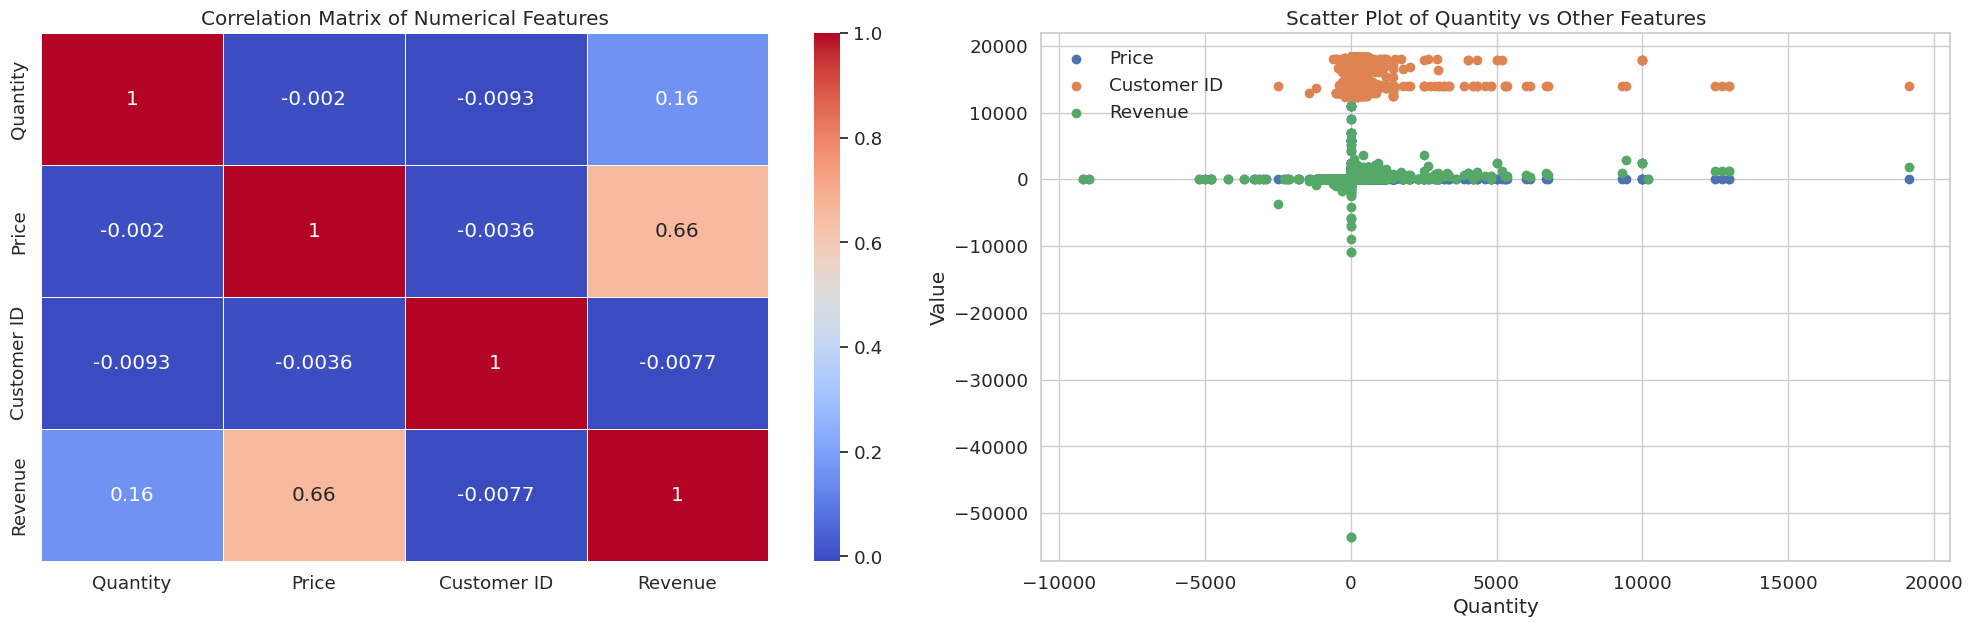

In [ ]:
print("\n\n## Preprocessing Visualization 4: Correlation Analysis")
print("Analyzing relationships between features...")

plt.figure(figsize=(20, 12))

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

if len(numerical_cols) >= 2:
    correlation = df[numerical_cols].corr()
    plt.subplot(2, 2, 1)
    sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix of Numerical Features')

    important_cols = numerical_cols[:4]
    if len(important_cols) >= 2:
        plt.subplot(2, 2, 2)
        for i in range(1, len(important_cols)):
            plt.scatter(df[important_cols[0]], df[important_cols[i]])
        plt.xlabel(important_cols[0])
        plt.ylabel('Value')
        plt.title(f'Scatter Plot of {important_cols[0]} vs Other Features')
        plt.legend(important_cols[1:])

    if 'Quantity' in df.columns and 'UnitPrice' in df.columns:
        plt.subplot(2, 2, 3)
        plt.scatter(df['UnitPrice'].clip(upper=df['UnitPrice'].quantile(0.95)),
                    df['Quantity'].clip(upper=df['Quantity'].quantile(0.95)))
        plt.xlabel('Unit Price')
        plt.ylabel('Quantity')
        plt.title('Relationship between Unit Price and Quantity')

    if 'Revenue' in df.columns and 'CustomerID' in df.columns:
        plt.subplot(2, 2, 4)
        customer_revenue = df.groupby('CustomerID')['Revenue'].sum().reset_index()
        customer_revenue = customer_revenue.sort_values('Revenue', ascending=False).head(20)
        sns.barplot(x='Revenue', y='CustomerID', data=customer_revenue)
        plt.title('Top 20 Customers by Revenue')
    elif 'Quantity' in df.columns and 'CustomerID' in df.columns:
        plt.subplot(2, 2, 4)
        customer_quantity = df.groupby('CustomerID')['Quantity'].sum().reset_index()
        customer_quantity = customer_quantity.sort_values('Quantity', ascending=False).head(20)
        sns.barplot(x='Quantity', y='CustomerID', data=customer_quantity)
        plt.title('Top 20 Customers by Quantity')

    plt.tight_layout()
    plt.savefig('correlation_analysis.png')
    plt.show()
else:
    print("Not enough numerical columns for correlation analysis.")


In [ ]:

df_clean = df.copy()


if 'Customer ID' in df_clean.columns:

    df_clean['Customer ID'] = pd.to_numeric(df_clean['Customer ID'], errors='coerce')

    df_clean = df_clean.dropna(subset=['Customer ID'])

    df_clean['Customer ID'] = df_clean['Customer ID'].astype(int)


if 'Customer ID' in df_clean.columns:

    customer_df = df_clean.groupby('Customer ID').agg({
        'Invoice': 'nunique',
        'Quantity': 'sum',
        'Price': 'mean'
    }).reset_index()

    customer_df.columns = ['Customer ID', 'NumPurchases', 'TotalQuantity', 'AvgPrice']


    df_clean['Quantity'] = pd.to_numeric(df_clean['Quantity'], errors='coerce')
    df_clean['Price'] = pd.to_numeric(df_clean['Price'], errors='coerce')

    df_clean['Revenue'] = df_clean['Quantity'] * df_clean['Price']
    customer_revenue = df_clean.groupby('Customer ID')['Revenue'].sum().reset_index()
    customer_df = customer_df.merge(customer_revenue, on='Customer ID')

    if 'Country' in df_clean.columns:
        customer_country = df_clean.groupby('Customer ID')['Country'].agg(lambda x: x.value_counts().index[0]).reset_index()
        customer_df = customer_df.merge(customer_country, on='Customer ID')


    if 'StockCode' in df_clean.columns:
        unique_products = df_clean.groupby('Customer ID')['StockCode'].nunique().reset_index()
        unique_products.columns = ['Customer ID', 'UniqueProducts']
        customer_df = customer_df.merge(unique_products, on='Customer ID')


    if 'Revenue' in customer_df.columns:
        median_revenue = customer_df['Revenue'].median()
        customer_df['Converted'] = (customer_df['Revenue'] > median_revenue).astype(int)
    else:
        median_purchases = customer_df['NumPurchases'].median()
        customer_df['Converted'] = (customer_df['NumPurchases'] > median_purchases).astype(int)

    print("\nCustomer-level aggregated data:")
    display(customer_df.head())
    print(f"\nConversion rate: {customer_df['Converted'].mean():.2%}")

    print("\nSimulating marketing channel exposure data...")
    np.random.seed(42)

    n_customers = len(customer_df)
    customer_df['Email_Campaign'] = np.random.binomial(1, 0.4, n_customers)
    customer_df['Social_Media'] = np.random.binomial(1, 0.3, n_customers)
    customer_df['Search_Engine'] = np.random.binomial(1, 0.5, n_customers)
    customer_df['Referral'] = np.random.binomial(1, 0.2, n_customers)
    customer_df['Direct'] = np.random.binomial(1, 0.6, n_customers)

    for channel in ['Email_Campaign', 'Social_Media', 'Search_Engine', 'Referral', 'Direct']:

        adjustment = 0.2 * customer_df['Converted']
        customer_df[channel] = np.where(
            customer_df[channel] + adjustment > 0.5,
            1, 0
        )

    print("\nAggregated data with simulated marketing channels:")
    display(customer_df.head())


    channel_cols = ['Email_Campaign', 'Social_Media', 'Search_Engine', 'Referral', 'Direct']
    channel_distribution = customer_df[channel_cols].mean()
    print("\nMarketing channel distribution:")
    display(channel_distribution)

    print("\nConversion rates by marketing channel:")
    for channel in channel_cols:
        conv_rate = customer_df.groupby(channel)['Converted'].mean()
        print(f"{channel}: No: {conv_rate[0]:.2%}, Yes: {conv_rate[1]:.2%}")

    print("\nChecking for infinity or NaN values in features...")
    print(customer_df.isna().sum())
    print(customer_df.isin([np.inf, -np.inf]).sum())


    customer_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    for col in customer_df.columns:
        if customer_df[col].dtype in ['int64', 'float64']:
            customer_df[col].fillna(customer_df[col].median(), inplace=True)

    X = customer_df.drop(['Customer ID', 'Converted'], axis=1)
    y = customer_df['Converted']

    print("\nFeature columns:", X.columns.tolist())
    print(f"Target distribution: {y.value_counts().to_dict()}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    print(f"\nTraining data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")


Customer-level aggregated data:


,Customer ID,NumPurchases,TotalQuantity,AvgPrice,Revenue,Country,UniqueProducts,Converted
0,12346,11,50.0,11.170000,127.05,United Kingdom,8,0
1,12349,3,469.0,8.052500,1244.37,Italy,49,1
2,12355,1,303.0,2.399091,488.21,Bahrain,22,1
3,12358,1,309.0,5.637647,1429.83,Austria,17,1
4,12359,6,561.0,4.837000,1428.23,Cyprus,65,1



Conversion rate: 50.00%

Simulating marketing channel exposure data...

Aggregated data with simulated marketing channels:


,Customer ID,NumPurchases,TotalQuantity,AvgPrice,Revenue,Country,UniqueProducts,Converted,Email_Campaign,Social_Media,Search_Engine,Referral,Direct
0,12346,11,50.0,11.170000,127.05,United Kingdom,8,0,0,0,1,0,1
1,12349,3,469.0,8.052500,1244.37,Italy,49,1,1,1,1,0,1
2,12355,1,303.0,2.399091,488.21,Bahrain,22,1,1,1,1,1,0
3,12358,1,309.0,5.637647,1429.83,Austria,17,1,0,0,1,0,1
4,12359,6,561.0,4.837000,1428.23,Cyprus,65,1,0,0,0,0,1



Marketing channel distribution:


,0
Email_Campaign,0.406870
Social_Media,0.287890
Search_Engine,0.481586
Referral,0.196530
Direct,0.607295



Conversion rates by marketing channel:
Email_Campaign: No: 50.81%, Yes: 48.83%
Social_Media: No: 51.17%, Yes: 47.11%
Search_Engine: No: 49.66%, Yes: 50.37%
Referral: No: 49.80%, Yes: 50.81%
Direct: No: 50.59%, Yes: 49.62%

Checking for infinity or NaN values in features...
Customer ID       0
NumPurchases      0
TotalQuantity     0
AvgPrice          0
Revenue           0
Country           0
UniqueProducts    0
Converted         0
Email_Campaign    0
Social_Media      0
Search_Engine     0
Referral          0
Direct            0
dtype: int64
Customer ID       0
NumPurchases      0
TotalQuantity     0
AvgPrice          0
Revenue           0
Country           0
UniqueProducts    0
Converted         0
Email_Campaign    0
Social_Media      0
Search_Engine     0
Referral          0
Direct            0
dtype: int64

Feature columns: ['NumPurchases', 'TotalQuantity', 'AvgPrice', 'Revenue', 'Country', 'UniqueProducts', 'Email_Campaign', 'Social_Media', 'Search_Engine', 'Referral', 'Direct']
Ta


Model Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       355
           1       0.96      0.91      0.93       351

    accuracy                           0.93       706
   macro avg       0.93      0.93      0.93       706
weighted avg       0.93      0.93      0.93       706



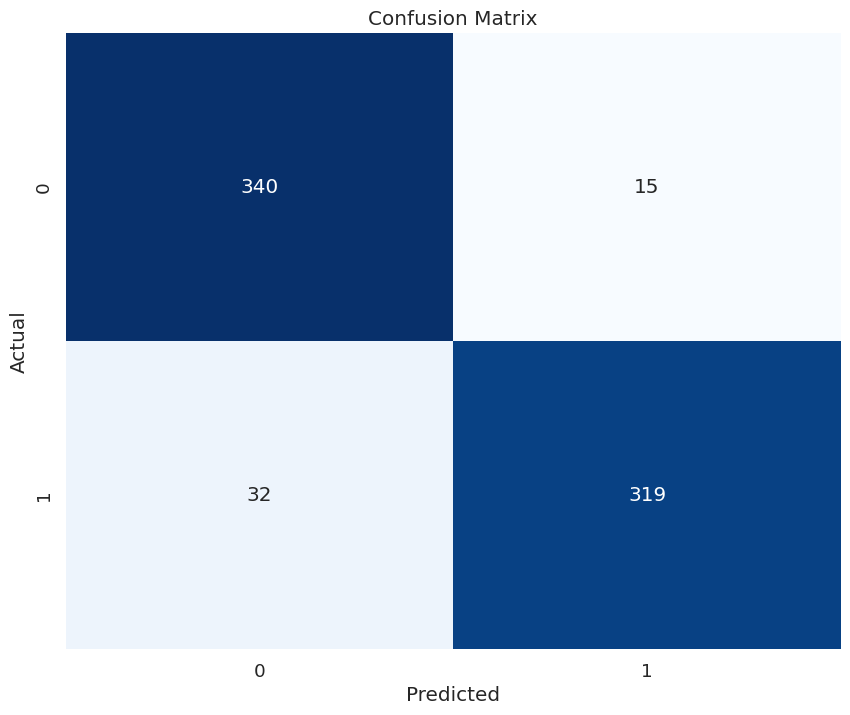

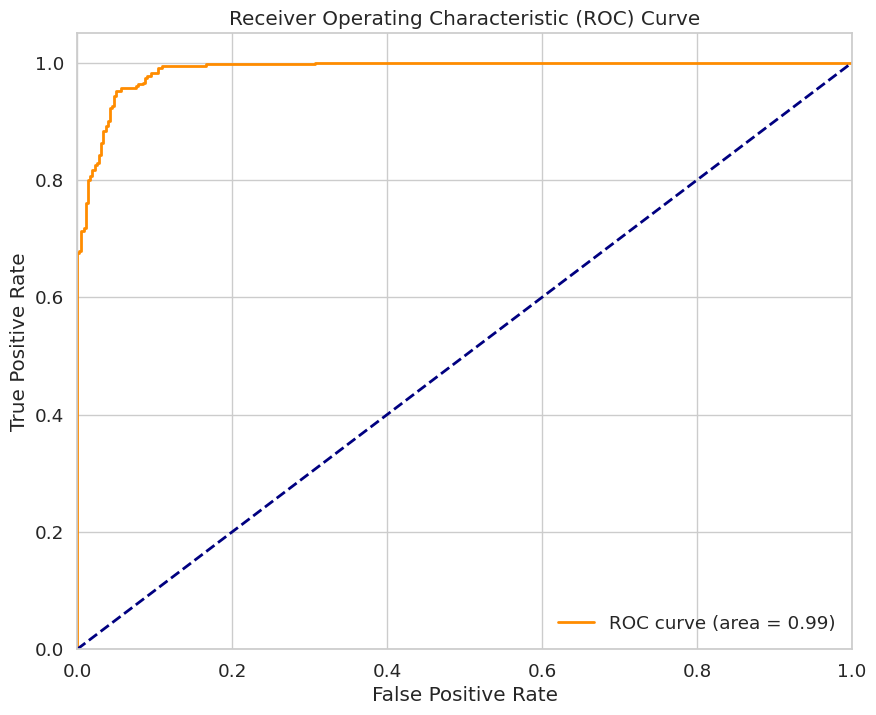

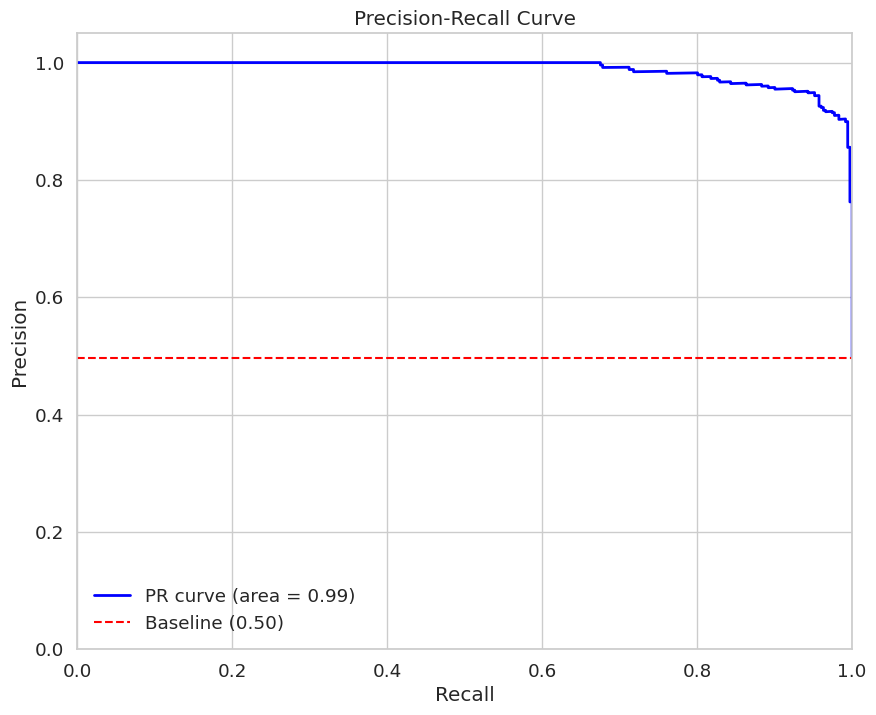

In [ ]:

categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

print("\nModel Evaluation:")
print("\nClassification Report:")
report = classification_report(y_test, y_pred)
print(report)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.show()


fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.axhline(y=y_test.mean(), color='red', linestyle='--', label=f'Baseline ({y_test.mean():.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig('precision_recall_curve.png')
plt.show()


Creating advanced attribution visualization...


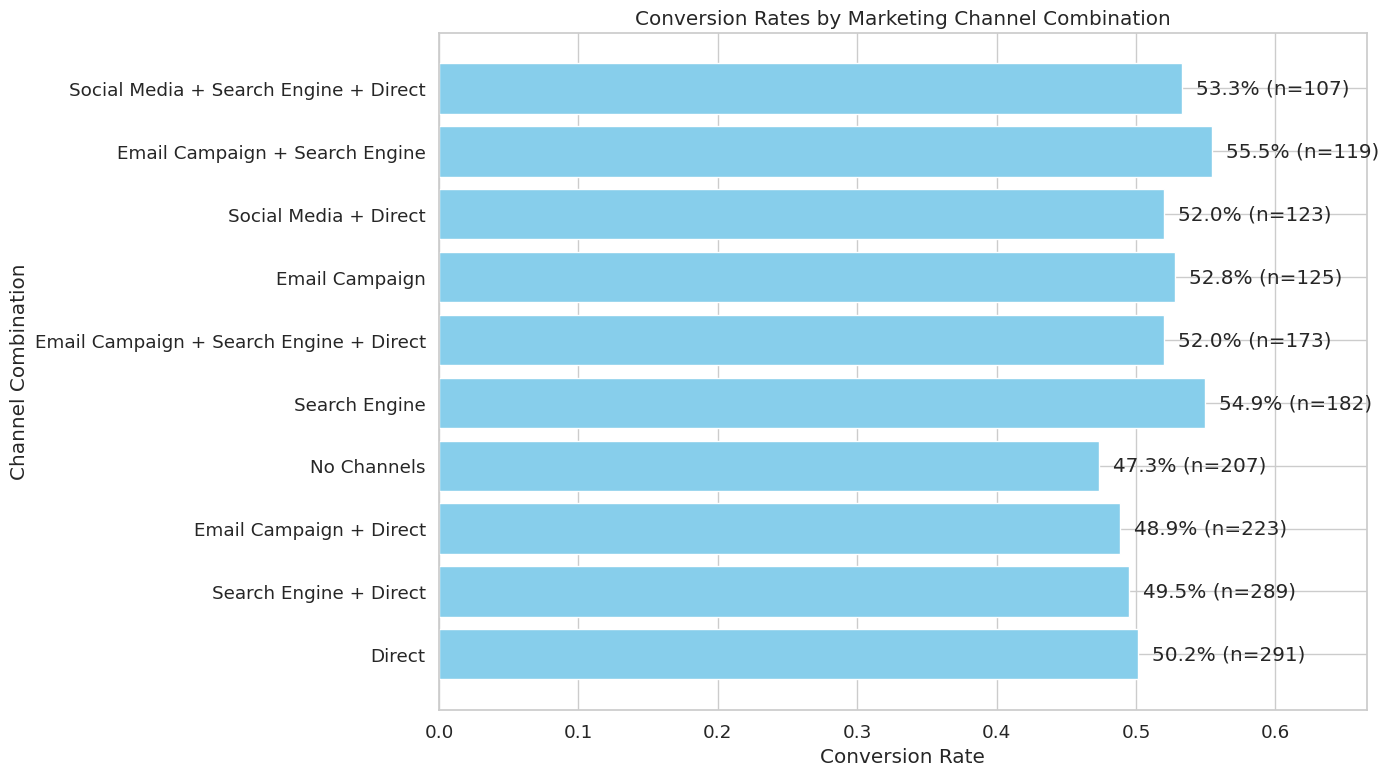


Multi-touch Attribution Analysis:


,Channel,With Channel Conv Rate,Without Channel Conv Rate,Absolute Lift,Relative Lift %,Exposures,Conversions
0,Email Campaign,0.488251,0.508060,-0.019809,-3.898961,1149,561
1,Social Media,0.471095,0.511686,-0.040591,-7.932802,813,383
2,Search Engine,0.503676,0.496585,0.007092,1.428109,1360,685
3,Referral,0.508108,0.498017,0.010091,2.026309,555,282
4,Direct,0.496210,0.505861,-0.009651,-1.907880,1715,851


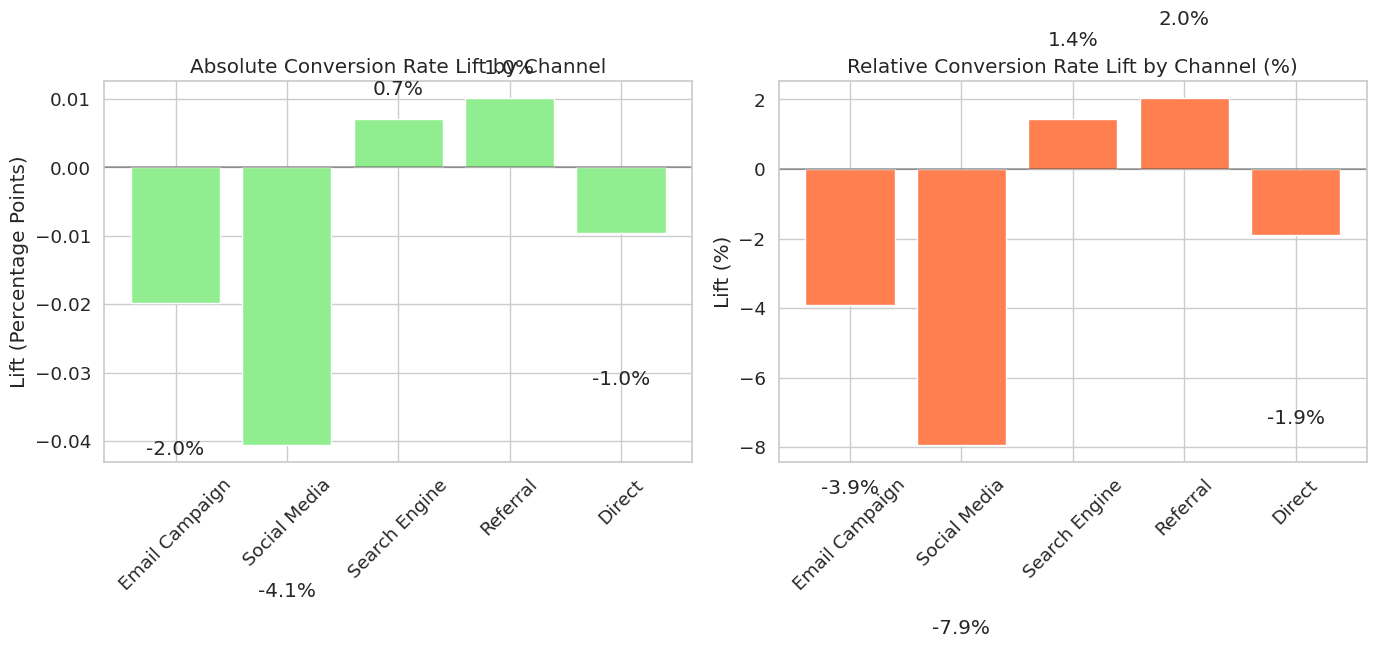



## ATTRIBUTION ANALYSIS: Channel Impact Assessment
Analyzing the impact of each marketing channel...

Feature Importance (Model Coefficients):


,Feature,Coefficient,AbsCoef
0,Revenue,13.889653,13.889653
1,TotalQuantity,5.341512,5.341512
2,NumPurchases,2.227626,2.227626
3,UniqueProducts,1.688278,1.688278
4,Country_United Kingdom,-0.838105,0.838105
5,Country_Cyprus,0.711781,0.711781
6,Country_Portugal,-0.608301,0.608301
7,Country_Norway,0.519155,0.519155
8,Country_Bahrain,0.457031,0.457031
9,Country_Austria,0.423743,0.423743


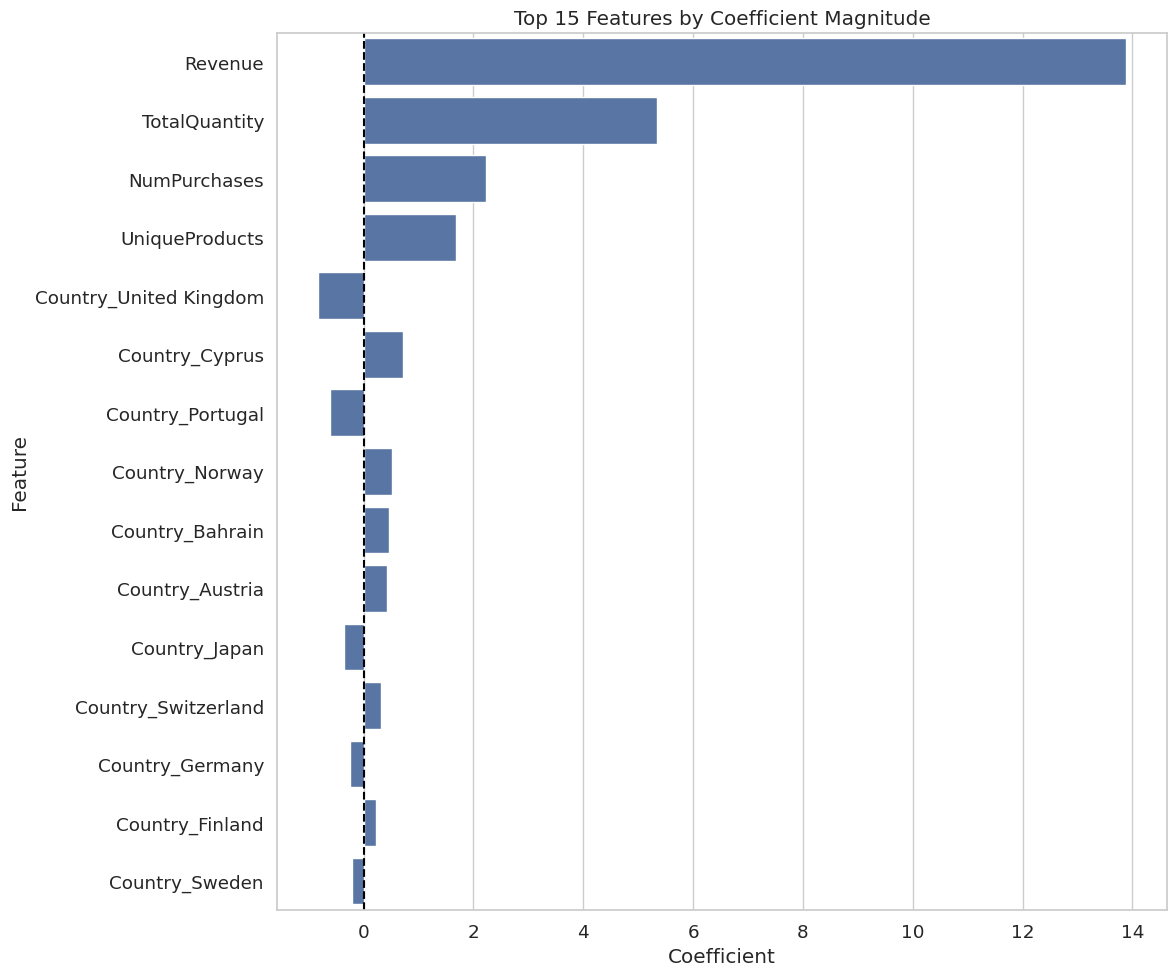

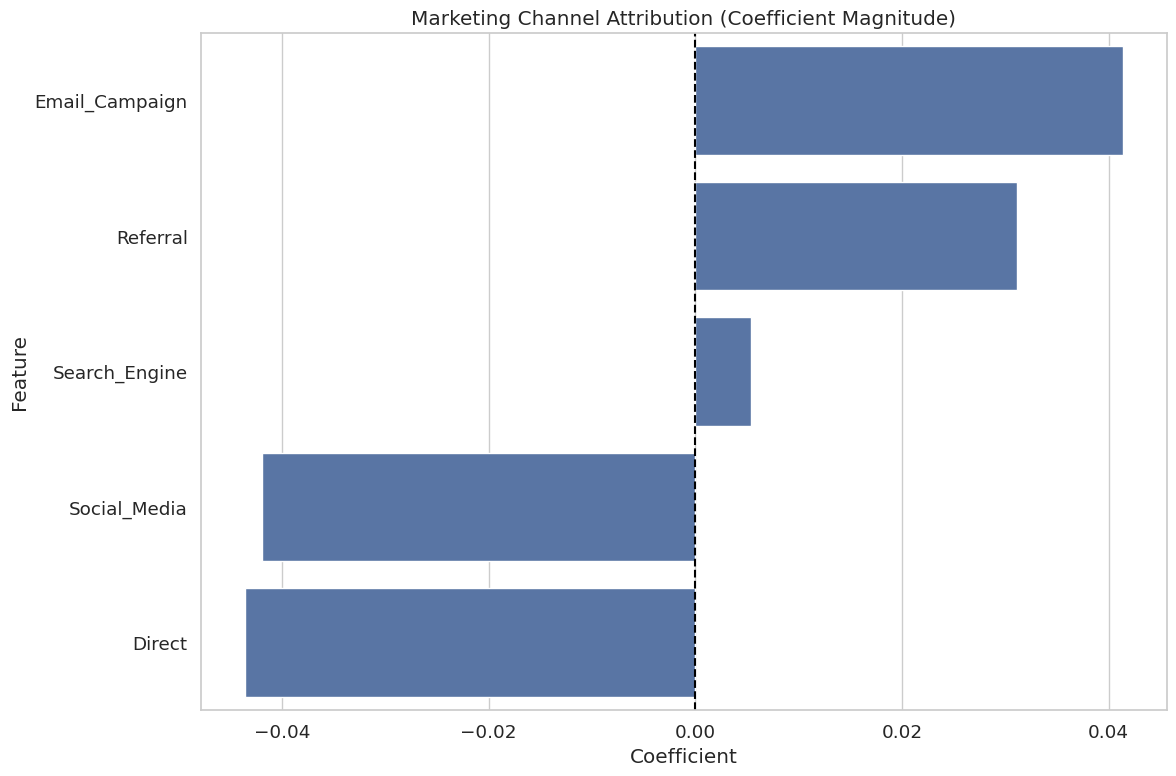


Marketing Channel Attribution Summary:
Direct: negative impact with coefficient of -0.0436
Social_Media: negative impact with coefficient of -0.0420
Email_Campaign: positive impact with coefficient of 0.0414
Referral: positive impact with coefficient of 0.0311
Search_Engine: positive impact with coefficient of 0.0053

Odds Ratios for Marketing Channels:
Direct: 1.04x lower odds of conversion
Social_Media: 1.04x lower odds of conversion
Email_Campaign: 1.04x higher odds of conversion
Referral: 1.03x higher odds of conversion
Search_Engine: 1.01x higher odds of conversion

Saving the model to disk...
Model saved as 'marketing_attribution_model.pkl'
Feature importance data saved as 'feature_importance.csv'

To load the model in the future, use:
import joblib
loaded_model = joblib.load('marketing_attribution_model.pkl')
# Then make predictions with:
predictions = loaded_model.predict(new_data)
probabilities = loaded_model.predict_proba(new_data)[:, 1]


In [ ]:

print("\nCreating advanced attribution visualization...")


channel_cols = ['Email_Campaign', 'Social_Media', 'Search_Engine', 'Referral', 'Direct']


customer_df['ChannelPattern'] = ''
for channel in channel_cols:
    customer_df['ChannelPattern'] += customer_df[channel].astype(str)

pattern_conv = customer_df.groupby('ChannelPattern')['Converted'].agg(['count', 'mean']).reset_index()
pattern_conv.columns = ['Pattern', 'Count', 'ConversionRate']
pattern_conv = pattern_conv.sort_values('Count', ascending=False).head(10)


pattern_labels = []
for pattern in pattern_conv['Pattern']:
    channels = []
    for i, val in enumerate(pattern):
        if val == '1':
            channels.append(channel_cols[i].replace('_', ' '))
    if not channels:
        pattern_labels.append('No Channels')
    else:
        pattern_labels.append(' + '.join(channels))

pattern_conv['Channels'] = pattern_labels


plt.figure(figsize=(14, 8))
bars = plt.barh(pattern_conv['Channels'], pattern_conv['ConversionRate'], color='skyblue')


for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
            f"{pattern_conv['ConversionRate'].iloc[i]:.1%} (n={pattern_conv['Count'].iloc[i]})",
            va='center')

plt.xlabel('Conversion Rate')
plt.ylabel('Channel Combination')
plt.title('Conversion Rates by Marketing Channel Combination')
plt.xlim(0, max(pattern_conv['ConversionRate']) * 1.2)
plt.tight_layout()
plt.savefig('channel_combinations.png')
plt.show()


print("\nMulti-touch Attribution Analysis:")

# Calculate the incremental effect of each channel
attribution_results = []

for channel in channel_cols:
    # Compare conversion with and without this channel
    with_channel = customer_df[customer_df[channel] == 1]['Converted'].mean()
    without_channel = customer_df[customer_df[channel] == 0]['Converted'].mean()
    lift = with_channel - without_channel
    lift_percent = lift / without_channel * 100 if without_channel > 0 else 0

    # Count exposures
    exposures = customer_df[channel].sum()
    conversions_with_channel = customer_df[(customer_df[channel] == 1) &
                                          (customer_df['Converted'] == 1)].shape[0]

    attribution_results.append({
        'Channel': channel.replace('_', ' '),
        'With Channel Conv Rate': with_channel,
        'Without Channel Conv Rate': without_channel,
        'Absolute Lift': lift,
        'Relative Lift %': lift_percent,
        'Exposures': exposures,
        'Conversions': conversions_with_channel
    })

attribution_df = pd.DataFrame(attribution_results)
display(attribution_df)

# Visualize the lift from each channel
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
bars = plt.bar(attribution_df['Channel'], attribution_df['Absolute Lift'], color='lightgreen')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.,
            height + 0.003 if height > 0 else height - 0.02,
            f"{height:.1%}",
            ha='center', va='bottom' if height > 0 else 'top')

plt.title('Absolute Conversion Rate Lift by Channel')
plt.ylabel('Lift (Percentage Points)')
plt.xticks(rotation=45)

# Plot relative lift
plt.subplot(1, 2, 2)
bars = plt.bar(attribution_df['Channel'], attribution_df['Relative Lift %'], color='coral')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.,
            height + 2 if height > 0 else height - 5,
            f"{height:.1f}%",
            ha='center', va='bottom' if height > 0 else 'top')

plt.title('Relative Conversion Rate Lift by Channel (%)')
plt.ylabel('Lift (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('channel_lift_analysis.png')
plt.show()

print("\n\n## ATTRIBUTION ANALYSIS: Channel Impact Assessment")
print("Analyzing the impact of each marketing channel...")

# Extract coefficients from the model
model = pipeline.named_steps['classifier']

# Get feature names after preprocessing
feature_names = []

if numerical_cols:
    feature_names.extend(numerical_cols)

if categorical_cols and len(categorical_cols) > 0:
    ohe = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
    cat_feature_names = ohe.get_feature_names_out(categorical_cols)
    feature_names.extend(cat_feature_names)

# Get coefficients for all features
coefficients = model.coef_[0]

# Create a DataFrame with coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort by absolute coefficient value
coef_df['AbsCoef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('AbsCoef', ascending=False).reset_index(drop=True)

print("\nFeature Importance (Model Coefficients):")
display(coef_df)

# Plot coefficients
plt.figure(figsize=(12, 10))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(15))
plt.title('Top 15 Features by Coefficient Magnitude')
plt.axvline(x=0, color='black', linestyle='--')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# Focus specifically on marketing channels
marketing_channels = ['Email_Campaign', 'Social_Media', 'Search_Engine', 'Referral', 'Direct']
channel_coef = coef_df[coef_df['Feature'].isin(marketing_channels)]

if not channel_coef.empty:
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=channel_coef.sort_values('Coefficient', ascending=False))
    plt.title('Marketing Channel Attribution (Coefficient Magnitude)')
    plt.axvline(x=0, color='black', linestyle='--')
    plt.tight_layout()
    plt.savefig('channel_attribution.png')
    plt.show()

    # Print channel attribution summary
    print("\nMarketing Channel Attribution Summary:")
    for idx, row in channel_coef.iterrows():
        impact = "positive" if row['Coefficient'] > 0 else "negative"
        print(f"{row['Feature']}: {impact} impact with coefficient of {row['Coefficient']:.4f}")

    # Calculate odds ratios for interpretation
    channel_coef['OddsRatio'] = np.exp(channel_coef['Coefficient'])
    print("\nOdds Ratios for Marketing Channels:")
    for idx, row in channel_coef.iterrows():
        if row['Coefficient'] > 0:
            print(f"{row['Feature']}: {row['OddsRatio']:.2f}x higher odds of conversion")
        else:
            print(f"{row['Feature']}: {1/row['OddsRatio']:.2f}x lower odds of conversion")
else:
    print("No marketing channel features found in the model.")

# Save the model to disk
import joblib

# Save the full pipeline (preprocessing + model)
print("\nSaving the model to disk...")
joblib.dump(pipeline, 'marketing_attribution_model.pkl')
print("Model saved as 'marketing_attribution_model.pkl'")

# Optional: Save feature importance data
coef_df.to_csv('feature_importance.csv', index=False)
print("Feature importance data saved as 'feature_importance.csv'")

# How to load the model for future use:
print("\nTo load the model in the future, use:")
print("import joblib")
print("loaded_model = joblib.load('marketing_attribution_model.pkl')")
print("# Then make predictions with:")
print("predictions = loaded_model.predict(new_data)")
print("probabilities = loaded_model.predict_proba(new_data)[:, 1]")